In [1]:
import numpy as np
import random
from datetime import datetime
from sklearn.datasets import load_iris,fetch_mldata
from sklearn.linear_model import Perceptron
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
print("Tensorflow:", tf.__version__)

import sys
print("Python Version:", sys.version)

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

(u'Tensorflow:', '1.1.0')
(u'Python Version:', '2.7.14 |Anaconda, Inc.| (default, Dec  7 2017, 17:05:42) \n[GCC 7.2.0]')


# Exercise 1
What are the advantages of a CNN over a fully connected DNN for image classification?

1. CNN weights are only partially connected. Less weights to train so its faster to train, less trianing data, and reduce the risk of overfitting. 
2. CNNs have an idea of nearby pixels. DNNs don't. 
3. Once a CNN learns feature in one part of an image, it can find that same feature on other parts of an image.

# Exercise 2
Consider a CNN composed of 3 convolutional layers, each with 3x3 kernels, a stride of 2, and SAME padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200x300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about training on a mini-batch of 50 images?

Welp...first. The first layer has 3x3 kernels with 3 maps, plus a bias. That all together is 28 parameters per kernel. Times the 100 feature maps is 2,800 parameters for the first layer. For the second layer, we have the same kinda 3x3 with now 100 maps from the last layer, plus a bias. That together is 901 per kernel. Times the 200 feature maps is 180,200 for the second layer. For the third layer, we have 3x3 kernels for 200 maps from the last layer, plus a bias. Together, that is 1,801. Times the 400 feature maps is 720,400 parameters. Add all those together, we have 2,800 + 180,200 + 720,400 = 903,400.

For RAM space for predicting 1 image, it's gonna be a bit more complicated. Since we are using a stride of 2, we are shrinking the image by 2 each time. So a 200x300 turns into a 100x150 after the first layer, a 50x75 after the second layer, and 25x38 after the third. A float is a 32-bit, or 4 byte, value. Times the feature maps of the first layer, we get 4x100x150x100 = 6,000,000 bytes. The second layer is 4x50x75x200 = 3,000,000 bytes. The last, following the pattern here, is near 1,500,000 bytes. But TF freees memory when it needs to, so we just have to compute the maximum of two adjacent layers which is 9,000,000 million bytes. Plus the memory it takes to store  the 903,400 parameters (3,613,300 bytes), is 12,613,300 bytes or around 12 MB.

Training on a minibatch is more intense. TF stores values of each instance for back propagation. So we multipy 50 x (6,000,000 + 3,000,000 + 1,500,000), which is 525,000,000 bytes. We add that to the size of all 50 images, 50 x (3x200x300) x 4 = 36,000,000. We add all of that with the size of the parameters, which is 3,613,300 bytes. Plus gradient variables, but they get initialize and destroyed fairly quickly, so we can assume the maximum would be the size of the max layer, 720,400x4 or 2,881,600 bytes. Add all of those together and we get 567,494,900 bytes or about 541 MB. 

# Exercise 3
If your GPU runs out of memory while training a CNN, what are 5 things you could try to solve the problem.

1. Fucking lower that batch size, ya twat.
2. Lower the number of layers. 
3. Larger strides to make the image smaller per layer
4. Use 16-bit floats
5. Distribute CNN

# Exercise 4
Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?

To subsample (or shrink) the input image to reduce computational load, memory usage, and the number of parameters.

# Exercise 5
When would you want to add a *local response normalization* layer?

When you don't want feature maps to learn similar features, most likely implemented in the lower layers of a CNN to generalize better. It encourages different maps to specialize and push them apart and force them to explore a wider range of features.

# Exercise 6
Innovations of AlexNet, compared to LeNet-5? What about GoogLeNet and ResNet.

1. AlexNet stacked Conv layers right on top of each other and used LRNs to normalize feature maps.
2. GoogLeNet created subnetworks calls inception modules wthat distributed the input across independent layers to be joined later by a concat operator.
3. ResNet first introduced the idea of skip connections, bringing the output of a layer up 2 to 4 layers to the input of another to speed up training.

# Exercise 7

In [2]:
## Build your own CNN and try to achieve the highest possible 
## accuracy on MNIST.

# Hyperparameters
lr = 1e-4

reset_graph()
# Inputs
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, 784), name="X")
    X_reshape = tf.reshape(X, [-1, 28, 28, 1])
    y = tf.placeholder(tf.int64, shape=(None), name="y")
    training = tf.Variable(True)

# Actual model
with tf.name_scope("model"):
    with tf.name_scope("cnn"):
        conv1 = tf.layers.conv2d(inputs=X_reshape, 
                                 filters=32, 
                                 kernel_size=(5,5),
                                 padding="same",
                                 activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(conv1, 
                                        pool_size=(2,2), 
                                        strides=2)
        conv2 = tf.layers.conv2d(inputs=pool1, 
                                 filters=64, 
                                 kernel_size=(5,5),
                                 padding="same",
                                 activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, 
                                        pool_size=(2,2), 
                                        strides=2)
    
    with tf.name_scope("fully_connected"):
        flat = tf.reshape(pool2, [-1, 7*7*64])
        dense1 = tf.layers.dense(inputs=flat, 
                                 units=1024,
                                 activation=tf.nn.relu)
        drop = tf.layers.dropout(inputs=dense1, training=train ing)
        logits = tf.layers.dense(inputs=drop, units=10)
        predictions = {
            "classes": tf.argmax(logits, axis=1),
            "probabilities": tf.nn.softmax(logits, name="softmax")
        }

# Loss functions 
with tf.name_scope("eval"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# Holds training ops
with tf.name_scope("train"):
    optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss=loss)

# Eval Metrics
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    pre_precision = tf.metrics.precision(y, predictions['classes'])
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    pre = tf.reduce_mean(tf.cast(pre_precision, tf.float32))

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images
train_labels = mnist.train.labels
test_data = mnist.test.images
test_labels = mnist.test.labels

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [4]:
def make_batch(X, y, size):
    idxs = np.random.randint(0, len(X), batch_size)
    return X[idxs], y[idxs]

In [5]:
n_epochs = 1000
batch_size = 100
grab_metrics = 50
best_threshold = 0.001
num_of_mets = n_epochs // grab_metrics

train_pre = []
train_acc = []
test_pre = []
test_acc = []

init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
saver = tf.train.Saver()

acc_test_best = 0
steps_since_best = 0
best_ckpt = ""
epoch = 0

with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)
    while epoch < n_epochs and steps_since_best < 200:
        X_tr, y_tr = make_batch(train_data, 
                                train_labels, 
                                batch_size)
        if epoch % grab_metrics == 0:
            tr_p, tr_a, _ = sess.run([pre, acc, train_op], 
                                     feed_dict={X: X_tr, y: y_tr})
            te_p, te_a = sess.run([pre, acc], 
                                  feed_dict={X:test_data,
                                             y:test_labels,
                                             training:False})
            print("Accuracy:", (tr_a, te_a),
                  "Precision:", (tr_p, te_p))
            train_pre.append(tr_p)
            train_acc.append(tr_a)
            test_pre.append(te_p)
            test_acc.append(te_a)
            if acc_test_best < test_acc[-1]:
                if acc_test_best + best_threshold < test_acc[-1]:
                    steps_since_best = 0
                acc_test_best = test_acc[-1]
                best_ckpt = saver.save(sess, "./ckpts/epoch_" + str(epoch) + ".ckpt")
        else:
            sess.run(train_op, feed_dict={X: X_tr, y: y_tr})
        epoch += 1
        steps_since_best += 1
    saver.restore(sess, best_ckpt)
    save_path = saver.save(sess, "./my_model_final.ckpt")
        

Accuracy: (0.079999998, 0.1217) Precision: (0.47, 0.92118812)
Accuracy: (0.079999998, 0.139) Precision: (0.90231079, 0.90218461)
Accuracy: (0.38, 0.4152) Precision: (0.90225798, 0.91492414)
Accuracy: (0.66000003, 0.7001) Precision: (0.9275645, 0.93567836)
Accuracy: (0.82999998, 0.83850002) Precision: (0.94373566, 0.94901001)
Accuracy: (0.86000001, 0.89740002) Precision: (0.95427889, 0.95785487)
Accuracy: (0.88999999, 0.91960001) Precision: (0.96141648, 0.96402472)
Accuracy: (0.88, 0.935) Precision: (0.96661711, 0.96859127)
Accuracy: (0.92000002, 0.93129998) Precision: (0.97056663, 0.97210759)
Accuracy: (0.91000003, 0.94209999) Precision: (0.97364092, 0.97485018)
Accuracy: (0.94, 0.95380002) Precision: (0.97606182, 0.97708023)
Accuracy: (0.93000001, 0.95539999) Precision: (0.9780966, 0.97888887)
Accuracy: (0.94, 0.96200001) Precision: (0.97967899, 0.98038995)
Accuracy: (0.94999999, 0.96310002) Precision: (0.98110056, 0.98173594)
Accuracy: (0.94999999, 0.96560001) Precision: (0.98236179,

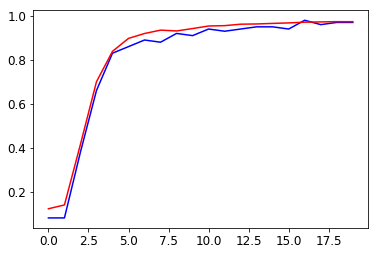

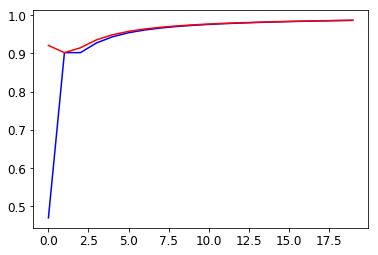

In [6]:
plt.plot(train_acc, color="blue")
plt.plot(test_acc, color="red")
plt.show()
plt.plot(train_pre, color="blue")
plt.plot(test_pre, color="red")
plt.show()